In [136]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


ERROR! Session/line number was not unique in database. History logging moved to new session 334


In [137]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu, threshold_adaptive, threshold_isodata, threshold_li, threshold_yen, denoise_bilateral, denoise_tv_bregman, denoise_tv_chambolle 
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.data import imread
from skimage.io import imsave
import sys
import os

(3679, 5518, 3)
(0, 20300722, 0L, 2368L, 700L, 3110L)


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: The default value for `background` will change to 0 in v0.12


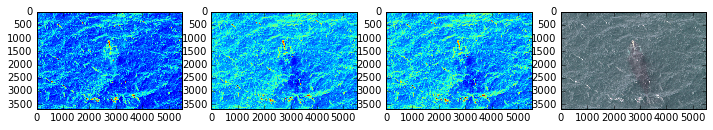

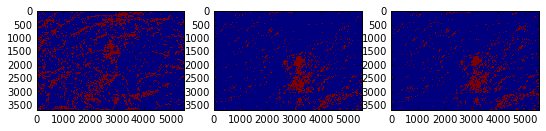

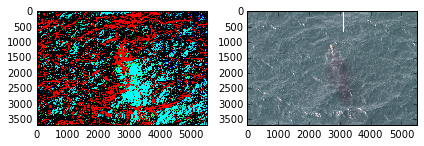

In [139]:
image_rgb = imread("/Users/alfiya/Documents/kaggle/WhalesFaceRecognition/imgs_subset/w_347.jpg")
print image_rgb.shape
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
ax[-1].imshow(image_rgb)

for c in np.arange(image_rgb.shape[2]):
    ax[c].imshow(image_rgb[:,:, c])

method = "threshold_percentile"
bw = np.zeros(shape=image_rgb.shape).astype(bool)
fig, ax = plt.subplots(1, 3, figsize=(9, 6))
for c in np.arange(image_rgb.shape[2]): 
    image = image_rgb[:,:, c].copy()
    p2, p90 = np.percentile(image.flatten(), [10, 80])
    bw[:,:, c] = (image < p2) if c > 0 else (image > p90)
    ax[c].imshow(bw[:,:,c])
# remove artifacts connected to image border
bw_ = bw[:,:,0] | bw[:,:,1] | bw[:,:,2]

# cleared = bw_.copy()
# clear_border(cleared)

# label image regions
label_image = label(bw_)
# borders = np.logical_xor(bw, cleared)
# label_image[borders] = -1
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6, 6))
ax[0].imshow(bw_)

m = 0
for region in regionprops(label_image):
    if region.area > m and cleared[label_image == region.label].mean() == True:
        m = region.area
        minr, minc, maxr, maxc = region.bbox
print(m, (image.shape[0]*image.shape[1]), minr, minc, maxr, maxc)
image_rgb_ = image_rgb.copy()  # [minr:maxr, minc:maxc, :]
image_rgb_[(minr-10):minr, minc:maxc, :] = (255, 255, 255)
image_rgb_[maxr:(maxr+10), minc:maxc, :] = (255, 255, 255)
image_rgb_[minr:maxr, maxc:(maxc+10), :] = (255, 255, 255)
image_rgb_[minr:maxr, (minc-10):minc, :] = (255, 255, 255)
ax[1].imshow(image_rgb_)
plt.tight_layout()


In [140]:
def threshold_percentile(image, percentile=[2, 90, 96]):  
#     print(percentile)
    p0, p1, p2 = np.percentile(image.flatten(), percentile)
    bw = (image < p0) | ((image <= p2) & (image > p1))
    return bw


def apply_threshold(image, threshold, **params):
#     print(params)
    thresh = globals()[threshold](image, **params)
    if thresh.shape != image.shape:
#         print("Threshold", thresh)
        res = closing(image > thresh, square(3))
    else: 
        res = thresh
    return res


def detect_whale(file_in, file_out, verbose, method, **params):
    image_rgb = imread(file_in)
    bw = np.zeros(shape=image_rgb.shape[:-1]).astype(bool)
    for c in np.arange(image_rgb.shape[2]):
        image = image_rgb.copy()[:, :, c]

        bw_ = apply_threshold(image, method, **params)
        bw = bw | bw_
    # remove artifacts connected to image border
    cleared = bw.copy()
#     clear_border(cleared)
    # label image regions
    label_image, n_labels = label(cleared, return_num=True)
    m = 0
    l = -1
    for region in regionprops(label_image):
        if region.area > m and cleared[label_image == region.label].mean() == True:
            m = region.area
            l = region.label
            minr, minc, maxr, maxc = region.bbox
#     image_rgb[(minr-10):minr, minc:maxc, :] = (255, 255, 255)
#     image_rgb[maxr:(maxr+10), minc:maxc, :] = (255, 255, 255)
#     image_rgb[minr:maxr, maxc:(maxc+10), :] = (255, 255, 255)
#     image_rgb[minr:maxr, (minc-10):minc, :] = (255, 255, 255)
    imsave(file_out, image_rgb[minr:maxr, minc:maxc, :])
    
    if verbose:
        print(m, minr, maxr, minc, maxc)
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(cleared)
        ax[1].imshow(label_image == l)
        ax[2].imshow(image_rgb)
        plt.tight_layout()


In [141]:
PATH2IMG = "/Users/alfiya/Documents/kaggle/WhalesFaceRecognition/imgs"
PATH2PROCESSEDIMG = os.path.join(PATH2IMG, "processed")
if not os.path.exists(PATH2PROCESSEDIMG):
    os.makedirs(PATH2PROCESSEDIMG)
for f in os.listdir(PATH2IMG):
    file_in = os.path.join(PATH2IMG,f)
    filename, file_extension = os.path.splitext(file_in)
#     print file_extension
    if os.path.isfile(file_in) and file_extension == ".jpg":
        file_out = os.path.join(PATH2PROCESSEDIMG, f)
#         print file_in
#         print file_out
        detect_whale(file_in, file_out, False, "threshold_percentile", percentile=[5, 90, 100])

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: The default value for `background` will change to 0 in v0.12


In [142]:
from PIL import Image

In [ ]:
def transform_image(file_in, file_out, width=300, height=200):
    img = Image.open(file_in)
    if np.array(img).shape[0] > np.array(img).shape[1]:
        img = img.rotate(90)
    img_out = img.resize((width, height), Image.ANTIALIAS)
    img_out.save(file_out) 
    
PATH2IMG = "/Users/alfiya/Documents/kaggle/WhalesFaceRecognition/imgs/processed"
PATH2PROCESSEDIMG = os.path.join(os.path.dirname(PATH2IMG), "processed_v2")
if not os.path.exists(PATH2PROCESSEDIMG):
    os.makedirs(PATH2PROCESSEDIMG)
for f in os.listdir(PATH2IMG):
    file_in = os.path.join(PATH2IMG,f)
    filename, file_extension = os.path.splitext(file_in)
#     print file_extension
    if os.path.isfile(file_in) and file_extension == ".jpg":
        file_out = os.path.join(PATH2PROCESSEDIMG, f)
#         print file_in
#         print file_out
        transform_image(file_in, file_out)